In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint, shuffle
from sklearn.metrics import accuracy_score, RocCurveDisplay
from collections import defaultdict, Counter

In [3]:
# Load all of our data:

We should only need deck states and card choice data from the test set, but we'll pull everything in regardless.

In [4]:
df_states_train = pd.read_json("deck_states_train.json")
df_states_test = pd.read_json("deck_states_test.json")
df_states_train.head()

,floor_0,floor_1,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_9,...,floor_47,floor_48,floor_49,floor_50,floor_51,floor_52,floor_53,floor_54,floor_55,floor_56
d96b9fad-367a-4eca-a51c-86735e6f1324,"[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...",...,"[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ...","[AscendersBane, Defend_R, Defend_R, Defend_R, ..."
c7df944f-670e-4983-bc49-b065e7153c31,"[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...",...,"[AscendersBane, Bash, Uppercut+1, Immolate+1, ...",None,None,None,None,None,None,None,None,None
a225c425-b0f4-4651-bad7-d832401f0e61,"[AscendersBane, Strike_G, Defend_G, Strike_G, ...","[AscendersBane, Strike_G, Defend_G, Strike_G, ...","[AscendersBane, Strike_G, Defend_G, Strike_G, ...","[AscendersBane, Strike_G, Defend_G, Strike_G, ...","[AscendersBane, Defend_G, Strike_G, Defend_G, ...","[AscendersBane, Defend_G, Strike_G, Defend_G, ...","[AscendersBane, Defend_G, Strike_G, Defend_G, ...","[AscendersBane, Defend_G, Strike_G, Defend_G, ...","[AscendersBane, Defend_G, Strike_G, Defend_G, ...","[AscendersBane, Defend_G, Strike_G, Defend_G, ...",...,"[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Defend_G, Defend_G, Defend_G, ...","[AscendersBane, Strike_G, Strike_G+1, Defend_G..."
167db9c8-c92d-4593-bd76-af330f57bb95,"[AscendersBane, Strike_P, Defend_P, Strike_P, ...","[AscendersBane, Strike_P, Defend_P, Strike_P, ...","[AscendersBane, Strike_P, Defend_P, Strike_P, ...","[AscendersBane, Strike_P, Defend_P, Strike_P, ...","[AscendersBane, Strike_P, Defend_P, Strike_P, ...","[AscendersBane, Strike_P, Strike_P, Defend_P, ...","[AscendersBane, Strike_P, Strike_P, Defend_P, ...","[AscendersBane, Strike_P, Strike_P, Defend_P, ...","[AscendersBane, Strike_P, Strike_P, Defend_P, ...","[AscendersBane, Strike_P, Strike_P, Defend_P, ...",...,"[AscendersBane, Strike_P, Strike_P, Defend_P, ...","[AscendersBane, Strike_P, Strike_P, Defend_P, ...","[AscendersBane, Strike_P, Strike_P, Defend_P, ...","[AscendersBane, Eruption+1, Vigilance, EmptyBo...",None,None,None,None,None,None
c9b8ca2d-f31d-49c8-b0ee-dfaa23af6e5e,"[AscendersBane, Strike_G, Defend_G, Strike_G, ...","[AscendersBane, Strike_G, Defend_G, Strike_G, ...","[AscendersBane, Strike_G, Defend_G, Strike_G, ...","[AscendersBa

In [5]:
def recommend_random(cards, floor):
    n_remaining = 1000
    cur_card = 0
    prob = {card: 0 for card in cards}
    shuffle(cards)
    asc = True
    while n_remaining > 0:
        rand = randint(0, np.ceil(n_remaining*0.5))
        n_remaining -= rand
        prob[cards[cur_card]] += rand/1000
        if (asc and cur_card+1 == len(cards)) or (not asc and cur_card == 0):
            asc = not asc
        elif asc:
            cur_card += 1
        else:
            cur_card -= 1
    for card, probs in prob.items():
        prob[card] = np.round(probs, 3)
    return prob

This dataframe contains the pickrates of each card by a certain floor. Our first model (after the random baseline) will just recommend the card with the highest pickrate.

In [6]:
df_pickrates = pd.read_json("pickrates_train.json")
df_pickrates.head()

,AscendersBane,Defend_R,Bash,Searing Blow,Warcry,Pommel Strike,Power Through,Corruption,Feel No Pain,Sentinel,...,Mayhem,Establishment,Secret Technique,WindmillStrike,Shame,Hyperbeam,WreathOfFlame,Regret,Chrysalis,Metamorphosis
0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.187500,1.000000,0.000000,...,0.257143,0.000,0.1,0.000000,0,0.250000,0.000000,0,0.037037,0.157895
1,0,0,0,0.421875,0.050955,0.492462,0.314815,0.187500,0.361111,0.096774,...,0.257143,0.000,0.1,0.250000,0,0.250000,0.125000,0,0.037037,0.157895
2,0,0,0,0.368421,0.053659,0.495935,0.333333,0.210526,0.384615,0.086957,...,0.257143,0.125,0.1,0.400000,0,0.250000,0.133333,0,0.037037,0.157895
3,0,0,0,0.357895,0.049242,0.483660,0.340000,0.200000,0.381579,0.073529,...,0.257143,0.125,0.1,0.388889,0,0.250000,0.115385,0,0.037037,0.157895
4,0,0,0,0.336207,0.056604,0.470899,0.355372,0.181818,0.357895,0.076087,...,0.257143,0.300,0.1,0.367347,0,0.333333,0.093750,0,0.037037,0.157895


In [7]:
def recommend_card_at_floor(cards, floor):
    # Given a list of cards and a floor, returns the probabilities that each card would have been picked given a card reward of only those
    floor = int(float(floor))
    prob = {}
    for card in cards:
        card = card.split("+")[0] # get rid of upgrade (for now)
        if card not in df_pickrates.columns:
            prob[card] = 0
        else:
            prob[card] = df_pickrates.loc[floor, card]
    sum_probs = sum(prob.values())
    for key, value in prob.items():
        if sum_probs > 0:
            prob[key] = value/sum_probs
        else:
            prob[key] = 0
    return prob

In [8]:
recommend_random(["Double Tap", "Corruption", "Bludgeon"], 15)

{'Double Tap': 0.521, 'Corruption': 0.391, 'Bludgeon': 0.088}

In [9]:
recommend_card_at_floor(["Double Tap", "Corruption", "Bludgeon"], 18)

{'Double Tap': 0.39122277777262326,
 'Corruption': 0.35798569429498056,
 'Bludgeon': 0.2507915279323962}

Now, we will import our data frame that contains all of our card choices on each floor, so we can evaluate each model based on ground truth.

In [10]:
df_cards_train = pd.read_json("cards_seen_picked_train.json")
df_cards_test = pd.read_json("cards_seen_picked_test.json")
df_cards_train.head()

,choices,seen
d96b9fad-367a-4eca-a51c-86735e6f1324,"{'1.0': 'Searing Blow', '2.0': 'Warcry', '5.0'...","{'1.0': ['Anger', 'Body Slam', 'Searing Blow']..."
c7df944f-670e-4983-bc49-b065e7153c31,"{'1': 'Combust', '4': 'Immolate', '6': 'Feel N...","{'1': ['Wild Strike', 'True Grit', 'Combust'],..."
a225c425-b0f4-4651-bad7-d832401f0e61,"{'1.0': 'Deadly Poison', '5.0': 'Catalyst', '6...","{'1.0': ['Catalyst', 'Blade Dance', 'Deadly Po..."
167db9c8-c92d-4593-bd76-af330f57bb95,"{'1': 'EmptyBody', '2': 'EmptyFist', '4': 'Cut...","{'1': ['ClearTheMind', 'Crescendo', 'EmptyBody..."
c9b8ca2d-f31d-49c8-b0ee-dfaa23af6e5e,"{'1.0': 'Cloak And Dagger', '6.0': 'Backflip',...","{'1.0': ['Blade Dance', 'Prepared', 'Cloak And..."


For now (because our only model is already trained on everything), we're just going to evaluate on the training set. I'll go back and split the data later.

In [11]:
def get_best_rec(rec_dict):
    best_prob = 0
    best_card = ""
    for card, prob in rec_dict.items():
        if prob > best_prob:
            best_prob = prob
            best_card = card
    
    return best_card, best_prob

In [12]:
def evaluate(model):
    preds = []
    probs = []
    actual = []
    
    rand_preds = []
    rand_probs = []
    rand_actual = []
    for index, row in df_cards_test.iterrows():
        choices = row["choices"]
        seen = row["seen"]
        
        for floor in seen:
            if float(floor) > 56:
                continue
            offered = seen[floor]
            picked = choices[floor]
            
            rec_card, rec_prob = get_best_rec(model(offered, floor))
            rand_card, rand_prob = get_best_rec(recommend_random(offered, floor))
            
            preds.append(1)
            rand_preds.append(1)
            
            probs.append(rec_prob)
            rand_probs.append(rand_prob)
            
            if rec_card.split("+")[0] == picked:
                actual.append(1)
            else:
                actual.append(0)
            if rand_card.split("+")[0] == picked:
                rand_actual.append(1)
            else:
                rand_actual.append(0)
    
    acc = accuracy_score(actual, preds)
    rand_acc = accuracy_score(rand_actual, rand_preds)
    
    fig = plt.figure()
    ax = fig.add_subplot()
    RocCurveDisplay.from_predictions(rand_actual, rand_probs, ax=ax,
                                     name="Random ROC Curve")
    RocCurveDisplay.from_predictions(actual, probs, ax=ax,
                                     name=f"{model.__name__} ROC Curve")
    plt.show()
    
    print(f"Model Accuracy: {acc:.2f}\nRandom Accuracy: {rand_acc:.2f}")

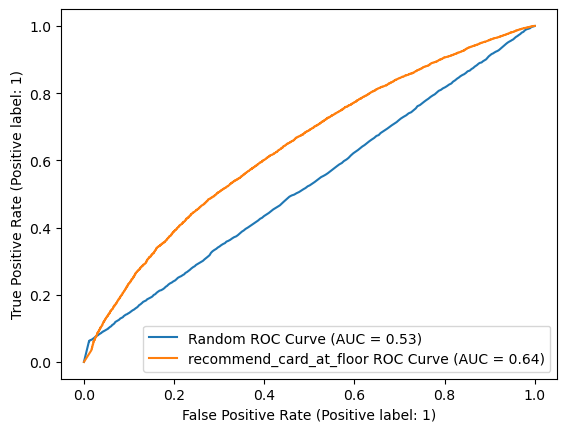

Model Accuracy: 0.49
Random Accuracy: 0.27


In [15]:
evaluate(recommend_card_at_floor)

Our pickrate heuristic almost manages to reach 50% accuracy, when we'd expect to reach 33% by just guessing randomly.

Next, I want to try another heuristic model that always recommends rare cards when available, then always recommends uncommon cards, then a random common card if no higher rarity cards are available.

On the Slay the Spire Discord, I found a list of all cards and metadata about them, including rarity. I'll be using this for the model:

In [13]:
cards_meta = pd.read_json("cards_meta.json").T["rarity"]
cards_meta.head()

Immolate                 RARE
Riddle With Holes    UNCOMMON
Self Repair          UNCOMMON
Quick Slash            COMMON
BootSequence         UNCOMMON
Name: rarity, dtype: object

In [14]:
cards_meta.loc["Riddle With Holes"]

'UNCOMMON'

In [15]:
def recommend_high_rarity(cards, floor):
    # Given a list of cards, recommend the highest rarity, or a random card of the highest rarity if there are multiple
    highest_rarity = ""
    rarest_cards = []
    for card in cards:
        rarity = cards_meta.loc[card.split("+")[0]]
        if highest_rarity == rarity:
            # Handles the case where there are multiple cards of the same rarity
            rarest_cards.append(card)
        elif (rarity == "RARE" or
              (highest_rarity != "RARE" and rarity == "UNCOMMON") or
              (highest_rarity == "" and rarity == "COMMON")):
            # Handles the case where a new highest rarity card is found
            rarest_cards = [card]
            highest_rarity = rarity
            
    # If only one rarest card, will return 100% chance of that card
    # Otherwise, will recommend a random one of the rarest cards
    recs = recommend_random(rarest_cards, floor)
    for card in cards:
        if card not in rarest_cards:
            recs[card] = 0.0
    
    return recs

In [44]:
recommend_high_rarity(["Dark Embrace+1", "Immolate+1", "Pommel Strike"], 10)

{'Immolate+1': 1.0, 'Dark Embrace+1': 0.0, 'Pommel Strike': 0.0}

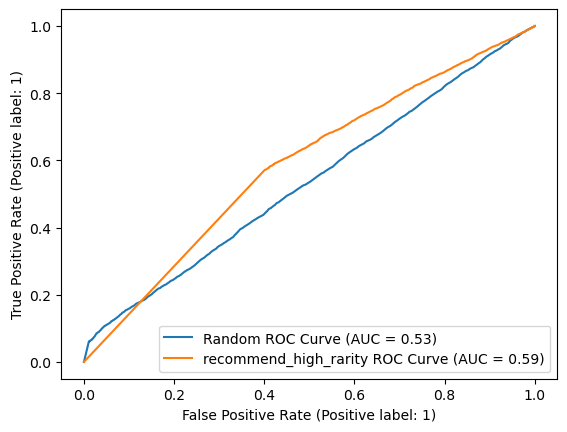

Model Accuracy: 0.35
Random Accuracy: 0.27


In [40]:
evaluate(recommend_high_rarity)

This one is barely better than random, so we're going to discard it and not go back to it. Turns out card rarity isn't that important (I could have figured that out on my own, but it was nice to try it)

Since the pickrate recommender worked fine, I want to try one that only looks at overall pickrate and ignores the current floor.

In [17]:
def recommend_card_pickrates(cards, floor):
    # Given a list of cards, returns the probabilities that each card would have been picked given a card reward of only those
    floor = 56 # Set floor to 56, the end of a run
    prob = {}
    for card in cards:
        card = card.split("+")[0] # get rid of upgrade (for now)
        if card not in df_pickrates.columns:
            prob[card] = 0
        else:
            prob[card] = df_pickrates.loc[floor, card]
    sum_probs = sum(prob.values())
    for key, value in prob.items():
        if sum_probs > 0:
            prob[key] = value/sum_probs
        else:
            prob[key] = 0
    return prob

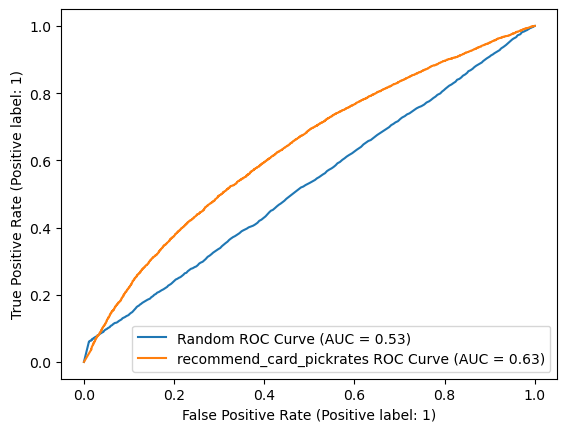

Model Accuracy: 0.48
Random Accuracy: 0.27


In [18]:
evaluate(recommend_card_pickrates)

This one is very slightly worse than the other model that used pickrates, which gives us the information that the floor matters but not to a significant degree. I'll be sure to test other models with and without floor information, when possible.

The next model I want to try is relatively similar to pick rate, but cares more about how often a card is present in the deck by a certain floor. This means that cards that get shown multiple times per run but always only picked exactly once will be recommended more often, since they'd appear in more final deck states.

In [34]:
df_appearance = pd.DataFrame(columns=cards_meta.index)
for floor in range(0, 57):
    dt = defaultdict(int)
    str_floor = f"floor_{floor}"
    col = df_states_train[str_floor]
    decks = 0
    for deck in col:
        if deck is None:
            continue
        decks += 1
        deck = list(dict.fromkeys([card.split("+")[0] for card in deck])) # Ignore upgrades and remove duplicates
        for card in deck:
            dt[card] += 1
    dt_fin = {}
    for card, num in dt.items():
        dt_fin[card] = [num/decks]
    #print(dt_fin)
    dt_fin = pd.DataFrame.from_dict(dt_fin)
    dt_fin.index = [floor]
    df_appearance = pd.concat([df_appearance, dt_fin])
    #print(dt_fin)
        
df_appearance

,Immolate,Riddle With Holes,Self Repair,Quick Slash,BootSequence,Gash,Bandage Up,Secret Technique,Calculated Gamble,DeusExMachina,...,Shame,Evolve,Double Tap,Strike_R,All Out Attack,Predator,Madness,Flying Knee,Singing Bowl,REME_ShadowForm
0,0.003738,NaN,NaN,0.000187,0.000187,NaN,0.000934,0.000748,NaN,NaN,...,NaN,NaN,0.000374,0.362362,NaN,NaN,NaN,NaN,NaN,NaN
1,0.003738,0.002243,0.004485,0.005420,0.002803,0.008223,0.000934,0.000748,0.002990,NaN,...,NaN,0.001495,0.000374,0.362362,0.003925,0.007288,NaN,0.007849,0.000187,NaN
2,0.004485,0.002429,0.008223,0.007662,0.005046,0.010092,0.001121,0.000748,0.003925,0.000374,...,0.000374,0.003177,0.000374,0.362362,0.004672,0.010465,0.000187,0.010839,0.000187,NaN
3,0.006167,0.003925,0.009718,0.010092,0.006167,0.013082,0.002056,0.000748,0.004672,0.000748,...,0.000374,0.004672,0.000748,0.362362,0.006354,0.011587,0.000187,0.015137,0.000374,NaN
4,0.008036,0.004298,0.013829,0.013082,0.007849,0.015137,0.002429,0.000748,0.005793,0.001121,...,0.000561,0.007475,0.001682,0.362362,0.008223,0.013642,0.000187,0.017754,0.000934,NaN
5,0.010652,0.004672,0.017380,0.015885,0.008783,0.017380,0.003364,0.000748,0.007101,0.001308,...,0.000561,0.009344,0.001869,0.362362,0.010092,0.014577,0.000187,0.021118,0.001308,NaN
6,0.014203,0.005233,0.019249,0.016819,0.010278,0.017941,0.003551,0.000748,0.007849,0.002616,...,0.000561,0.010278,0.004111,0.362362,0.011960,0.016446,0.000187,0.022799,0.002616,NaN
7,0.017567,0.005793,0.022426,0.018127,0.012521,0.018875,0.003925,0.000748,0.008970,0.003364,...,0.000561,0.012708,0.005793,0.362362,0.014016,0.018501,0.000187,0.023921,0.004111,NaN
8,0.019809,0.006167,0.024855,0.019436,0.013082,0.020557,0.004111,0.000748,0.009718,0.003738,...,0.000561,0.014390,0.007288,0.362362,0.014764,0.019249,0.000187,0.025416,0.006728,NaN
9,0.019809,0.006167,0.024855,0.019436,0.013082,0.020557,0.004111,0.000748,0.009718,0.003738,...,0.000561,0.014390,0.007288,0.362362,0.014764,0.019249,0.000187,0.025416,0.006728,NaN


Now that we have this table, we'll just use a similar recommender from above:

In [61]:
def recommend_card_app_rate(cards, floor):
    # Given a list of cards and a floor, returns the probabilities that each card would have been picked given a card reward of only those
    floor = int(float(floor))
    prob = {}
    for card in cards:
        card_unupg = card.split("+")[0] # get rid of upgrade (for now)
        if card_unupg not in df_appearance.columns:
            prob[card] = 0
        else:
            prob[card] = df_appearance.loc[floor, card_unupg]
    sum_probs = sum(prob.values())
    for key, value in prob.items():
        if sum_probs > 0:
            prob[key] = value/sum_probs
        else:
            prob[key] = 0
    return prob

In [63]:
recommend_card_app_rate(["Double Tap", "Corruption", "Pommel Strike"], 18)

{'Double Tap': 0.23583662714097497,
 'Corruption': 0.19367588932806323,
 'Pommel Strike': 0.5704874835309618}

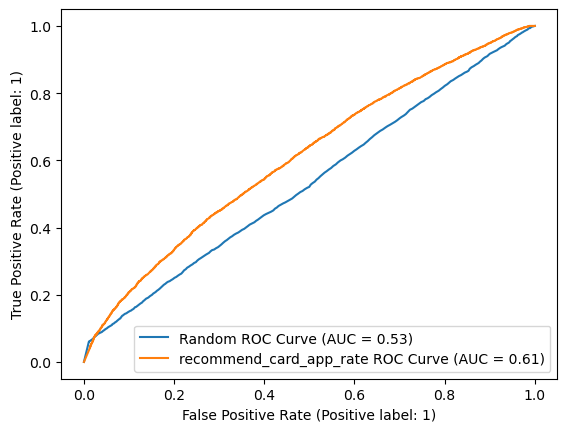

Model Accuracy: 0.40
Random Accuracy: 0.27


In [37]:
evaluate(recommend_card_app_rate)

This one is definitely worse. I think that's because it recommends rarer cards less often. What if we try a hybrid model between rarity and appearance rate?

In [79]:
def recommend_app_rarity_hybrid(cards, floor, WEIGHT=1):
    app_recs = recommend_card_app_rate(cards, floor)
    rarity_recs = recommend_high_rarity(cards, floor)
    out = {}
    ps = {}
    tot = 0
    for card in cards:
        p = app_recs[card] + WEIGHT * rarity_recs[card]
        ps[card] = p
        tot += p
        
    for card, p in ps.items():
        if tot > 0:
            out[card] = p/tot
        else:
            out[card] = 0.0

    return out

In [72]:
recommend_app_rarity_hybrid(["Double Tap+1", "Corruption", "Pommel Strike"], 18)

{'Double Tap+1': 0.3904183135704875,
 'Corruption': 0.32433794466403165,
 'Pommel Strike': 0.2852437417654809}

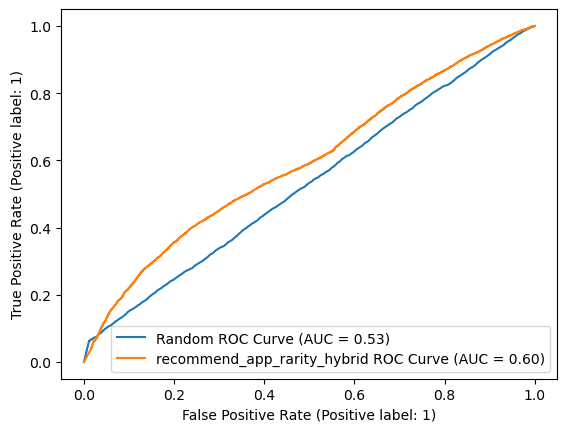

Model Accuracy: 0.43
Random Accuracy: 0.27


In [73]:
evaluate(recommend_app_rarity_hybrid)

Since we have a weight parameter, we need to tune it. We'll write a modified evaluator to handle that:

In [77]:
def evaluate_weights(model):
    preds = []
    probs = []
    actual = []
    
    rand_preds = []
    rand_probs = []
    rand_actual = []
    for weight in range(0, 101, 5):
        WEIGHT = weight / 100.0
        for index, row in df_cards_test.iterrows():
            choices = row["choices"]
            seen = row["seen"]

            for floor in seen:
                if float(floor) > 56:
                    continue
                offered = seen[floor]
                picked = choices[floor]

                rec_card, rec_prob = get_best_rec(model(offered, floor, WEIGHT))
                rand_card, rand_prob = get_best_rec(recommend_random(offered, floor))

                preds.append(1)
                rand_preds.append(1)

                probs.append(rec_prob)
                rand_probs.append(rand_prob)

                if rec_card.split("+")[0] == picked:
                    actual.append(1)
                else:
                    actual.append(0)
                if rand_card.split("+")[0] == picked:
                    rand_actual.append(1)
                else:
                    rand_actual.append(0)

        acc = accuracy_score(actual, preds)
        #rand_acc = accuracy_score(rand_actual, rand_preds)

        print(f"{WEIGHT=} Model Accuracy: {acc:.2f}\n")

In [80]:
evaluate_weights(recommend_app_rarity_hybrid)

WEIGHT=0.0 Model Accuracy: 0.40

WEIGHT=0.05 Model Accuracy: 0.41

WEIGHT=0.1 Model Accuracy: 0.41

WEIGHT=0.15 Model Accuracy: 0.42

WEIGHT=0.2 Model Accuracy: 0.42

WEIGHT=0.25 Model Accuracy: 0.43

WEIGHT=0.3 Model Accuracy: 0.43

WEIGHT=0.35 Model Accuracy: 0.44

WEIGHT=0.4 Model Accuracy: 0.44

WEIGHT=0.45 Model Accuracy: 0.44

WEIGHT=0.5 Model Accuracy: 0.44

WEIGHT=0.55 Model Accuracy: 0.45

WEIGHT=0.6 Model Accuracy: 0.45

WEIGHT=0.65 Model Accuracy: 0.45

WEIGHT=0.7 Model Accuracy: 0.45

WEIGHT=0.75 Model Accuracy: 0.45

WEIGHT=0.8 Model Accuracy: 0.45

WEIGHT=0.85 Model Accuracy: 0.45

WEIGHT=0.9 Model Accuracy: 0.45

WEIGHT=0.95 Model Accuracy: 0.45

WEIGHT=1.0 Model Accuracy: 0.45



Seems like none of our weights gets the model to be better than our original heuristic. I think it's time to start comparing deck states across runs. To do this, we need to change our deck states dataframe from one dataframe with lists of deck states, to 57 dataframes (floors 0-56) with each cell representing the number of that card (columns) in the deck (rows) at that floor.

In [281]:
def get_deck_state_dict(state_frame):
    deck_state_dict = {}
    for floor in range(0, 57):
        floor_df = pd.DataFrame(columns=cards_meta.index)
        floor_dt = {}
        col_name = f"floor_{floor}"
        col = state_frame[col_name]
                                
        for run, deck in col.items():
            deck2 = Counter(deck).most_common()
            deck2 = dict([(card.split("+")[0], ct) for card, ct in deck2])
            floor_dt[run] = deck2
        df_tmp = pd.DataFrame.from_dict(floor_dt, orient='index')
        # -5.0 is an arbitrary value here, I just want there to be more of a difference
        # between having 0 vs 1 of a card than having 1 vs 2 of a card
        # This can be tuned later
        floor_df = pd.concat([floor_df, df_tmp]).fillna(-5.0)
        # Singing Bowl and Skip messing things up again :( 
        # No clue what REME_ShadowForm is, but it's not a real card
        floor_df = floor_df.drop(["Singing Bowl", "SKIP", "REME_ShadowForm"], errors="ignore", axis=1)
        deck_state_dict[floor] = floor_df
    return deck_state_dict

In [282]:
floor_deck_states_train = get_deck_state_dict(df_states_train)

In [283]:
floor_deck_states_train[0].head()

,Immolate,Riddle With Holes,Self Repair,Quick Slash,BootSequence,Gash,Bandage Up,Secret Technique,Calculated Gamble,DeusExMachina,...,Neutralize,Multi-Cast,Shame,Evolve,Double Tap,Strike_R,All Out Attack,Predator,Madness,Flying Knee
d96b9fad-367a-4eca-a51c-86735e6f1324,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,5.0,-5.0,-5.0,-5.0,-5.0
c7df944f-670e-4983-bc49-b065e7153c31,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,5.0,-5.0,-5.0,-5.0,-5.0
82441ae8-9830-4734-b8e9-bb18dab43bfb,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,5.0,-5.0,-5.0,-5.0,-5.0
ff16764d-4329-47e5-be8a-d604207e0d77,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,5.0,-5.0,-5.0,-5.0,-5.0
f92d9327-39f7-435e-8655-ac0e2222fa53,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,5.0,-5.0,-5.0,-5.0,-5.0


In [284]:
floor_deck_states_test = get_deck_state_dict(df_states_test)

In [285]:
floor_deck_states_test[34]

,Immolate,Riddle With Holes,Self Repair,Quick Slash,BootSequence,Gash,Bandage Up,Secret Technique,Calculated Gamble,DeusExMachina,...,Neutralize,Multi-Cast,Shame,Evolve,Double Tap,Strike_R,All Out Attack,Predator,Madness,Flying Knee
406ea499-76aa-42f5-a09e-1e7ec20364ff,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
d0fe6964-6996-4454-8525-bb03d863c81b,-5.0,-5.0,1.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
bad6a794-9de5-43a8-8f31-1a9574b25566,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
9affa6c9-ddd9-4690-ac8e-fd49113eedb0,-5.0,-5.0,-5.0,-5.0,1.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
357efbe0-a24c-4e63-9e27-3cff3376aefb,-5.0,-5.0,1.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8369a637-255f-4bd0-9db1-089c5b5c44b0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,3.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,1.0
859f606b-85c3-45ed-bd60-792547943bbb,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,1.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
73d4b047-8033-437a-a0b9-f64c9543aca4,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,4.0,-5.0,-5.0,-5.0,-5.0
865d33fb-4ba6-47ea-ac06-fd90ffa7a3fd,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,1.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,1.0,-5.0,-5.0


In [286]:
floor_deck_states_test[0]["Immolate"].unique()

array([-5.,  1.])

With this, we can train models to recognize similarities between deck states, and find the runs that have the most similar deck states. Then, we can make recommendations based on what similar runs would have chosen.

We'll start with a KNN model, and determine how many of the nearest runs would have contained each of the cards in their deck by a certain point. This point could be the same floor, or a couple floors ahead if we want to account for decks that just haven't seen the card yet.

In [320]:
from sklearn.neighbors import NearestNeighbors

def recommend_similar_decks(cards, floor, deck_state):
    floor = int(float(floor))
    states = floor_deck_states_train[floor]
    states_p5 = floor_deck_states_train[min(46, floor+5)]
    knn = NearestNeighbors().fit(X=states.values) # k can be changed
    
    diff_cols = [col for col in states.columns if col not in deck_state.index]
    if len(diff_cols) > 0:
        print(diff_cols)
    
    deck_state = deck_state.values.reshape(1, -1)
    neighbors = knn.kneighbors(deck_state, n_neighbors=20)
    
    tot = 0
    count = defaultdict(int)
    for neighbor in neighbors[1][0]:
        n_id = states.iloc[neighbor].name
        try:
            n_state_p5 = states_p5.loc[n_id]
        except KeyError:
            continue
        for card in cards:
            n_cards = max(n_state_p5[card.split("+")[0]], 0)
            count[card] += n_cards
            tot += n_cards
    
    out = {}
    for card, ct in count.items():
        if tot > 0:
            out[card] = ct/tot
        else:
            out[card] = 0
            
    return out
        

In [321]:
recommend_similar_decks(["Defragment", "Ball Lightning", "Cold Snap"], 30, floor_deck_states_test[30].loc["406ea499-76aa-42f5-a09e-1e7ec20364ff"])

{'Defragment': 0.39285714285714285,
 'Ball Lightning': 0.30357142857142855,
 'Cold Snap': 0.30357142857142855}

We're going to have to modify the evaluator for this one, since we're now taking into account the current state of the deck.

In [324]:
def evaluate_state(model):
    preds = []
    probs = []
    actual = []
    
    rand_preds = []
    rand_probs = []
    rand_actual = []
    nrow = 0
    for index, row in df_cards_test.iterrows():
        nrow += 1
        if nrow % 50 == 0:
            print(f"Row {nrow}/{df_cards_test.shape[0]}")
        choices = row["choices"]
        seen = row["seen"]
        
        for floor in seen:
            if float(floor) > 56:
                continue
            offered = seen[floor]
            picked = choices[floor]
            if picked == "SKIP":
                print("SKIP")
            
            #print(floor_deck_states_test[float(floor)].loc[index])
            state = floor_deck_states_test[float(floor)].loc[index]
            #print(state)
            
            rec_card, rec_prob = get_best_rec(model(offered, floor, state))
            rand_card, rand_prob = get_best_rec(recommend_random(offered, floor))
            
            preds.append(1)
            rand_preds.append(1)
            
            probs.append(rec_prob)
            rand_probs.append(rand_prob)
            
            if rec_card.split("+")[0] == picked:
                actual.append(1)
            else:
                actual.append(0)
            if rand_card.split("+")[0] == picked:
                rand_actual.append(1)
            else:
                rand_actual.append(0)
    
    acc = accuracy_score(actual, preds)
    rand_acc = accuracy_score(rand_actual, rand_preds)
    
    fig = plt.figure()
    ax = fig.add_subplot()
    RocCurveDisplay.from_predictions(rand_actual, rand_probs, ax=ax,
                                     name="Random ROC Curve")
    RocCurveDisplay.from_predictions(actual, probs, ax=ax,
                                     name=f"{model.__name__} ROC Curve")
    plt.show()
    
    print(f"Model Accuracy: {acc:.2f}\nRandom Accuracy: {rand_acc:.2f}")

Row 50/1338
Row 100/1338
Row 150/1338
Row 200/1338
Row 250/1338
Row 300/1338
Row 350/1338
Row 400/1338
Row 450/1338
Row 500/1338
Row 550/1338
Row 600/1338
Row 650/1338
Row 700/1338
Row 750/1338
Row 800/1338
Row 850/1338
Row 900/1338
Row 950/1338
Row 1000/1338
Row 1050/1338
Row 1100/1338
Row 1150/1338
Row 1200/1338
Row 1250/1338
Row 1300/1338


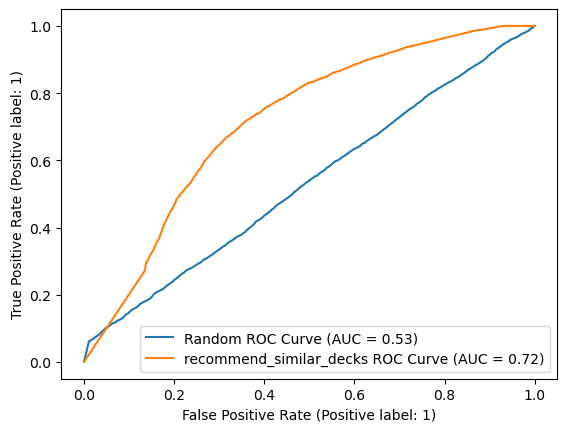

Model Accuracy: 0.65
Random Accuracy: 0.27


In [325]:
# This evaluator takes a lot longer, KNN is much much slower than a heuristic
evaluate_state(recommend_similar_decks)

While my goal was to reach 80% accuracy, I'm realizing now that it'll be harder to get there than I thought. 65% accuracy is already pretty good, and picks the correct card nearly 40% more than a random guess. I may still try making some improvements, but I'm happy with this one for now.